# DT visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import matplotlib
import ast

In [2]:
'''
Reference: https://stackoverflow.com/questions/10650645/python-calculate-voronoi-tesselation-from-scipys-delaunay-triangulation-in-3d
'''
def triangle_csc(pts):
    """
    Compute the circumscribed circle of a triangle.
    """
    rows, cols = pts.shape

    A = np.bmat([[2*np.dot(pts, pts.T), -np.ones((rows, 1))],
                    [np.ones((1, rows)), np.zeros((1, 1))]])
    b = np.hstack((np.sum(pts**2, axis=1), np.ones((1))))
    x = np.linalg.solve(A, b)
    bary_coords = x[:-1]
    return np.sum(pts * np.tile(bary_coords.reshape(pts.shape[0], 1), (1, pts.shape[1])), axis=0)

def voronoi(P):
    """
    Compute the Voronoi diagram of a set of points.
    """
    delaunay = Delaunay(P)
    triangles = delaunay.points[delaunay.vertices]

    lines = []

    # Triangle vertices
    A = triangles[:, 0]
    B = triangles[:, 1]
    C = triangles[:, 2]
    
    lines.extend(zip(A, B))
    lines.extend(zip(B, C))
    lines.extend(zip(C, A))
    lines = matplotlib.collections.LineCollection(lines, color='b', alpha=1, linewidth=1)
    
    plt.gca().add_collection(lines)

    circum_centers = np.array([triangle_csc(triangle) for triangle in triangles])

    segments = []
    for i, triangle in enumerate(triangles):
        circum_center = circum_centers[i]
        for j, neighbor in enumerate(delaunay.neighbors[i]):
            if neighbor != -1:
                segments.append((circum_center, circum_centers[neighbor]))
            else:
                ps = triangle[(j+1)%3] - triangle[(j-1)%3]
                ps = np.array([ps[1], -ps[0]])

                middle = (triangle[(j+1)%3] + triangle[(j-1)%3]) / 2
                di = middle - triangle[j]

                ps /= np.linalg.norm(ps)
                di /= np.linalg.norm(di)

                if np.dot(di, ps) < 0.0:
                    ps *= -1000.0
                else:
                    ps *= 1000.0
                segments.append((circum_center, circum_center + ps))
    return segments

def addPoint(scat, new_point):
    old_off = scat.get_offsets()
    new_off = np.concatenate([old_off, np.array(new_point, ndmin=2)])
    scat.set_offsets(new_off)

In [6]:
# PV 사이트 위치 정보 및 번호(지점번호와는 아무런 관계 X) scrapping 
PV_points = pd.read_csv(r'D:\Workspace\Dataset\태양광 발전 데이터\data_each_PV_info_20191201_20211028(bell).csv', index_col=0)
# PV_points = pd.read_csv(r'D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\PV_delaunay_tri(bell)_20211028_updated.csv')


# Bell shaped인 것만
PV_points = PV_points[PV_points.bell == True]
PV_points.reset_index(drop=True, inplace=True)

# PV_points['latitude'] = PV_points['latitude'].astype(np.float64)

# PV_loc = np.round(PV_points.loc[:,['longitude', 'latitude']].values, 6)
PV_loc = PV_points.loc[:,['longitude', 'latitude']].values.astype(float)
# PV_num = PV_points.loc[:,'번호'].values

# PV_points = pd.read_csv(r'C:\Users\kjson\OneDrive\바탕 화면\SKJ Box\MS(Sogang University)\SKJs Research\(개인연구용)data\동서발전 태양광 데이터\동서발전 태양광 발전량 예측 AI 경진대회_data\site_info.csv')
# PV_loc = PV_points.loc[:,['Longitude', 'Latitude']].values

# For '(ASOS)기상관측소 위치 정보_(sumup_ver)' excel file
## Note: 진도(첨찰산), 관악산 관측소 -> 지점코드에 속해있지 않음. 즉 기상 데이터 제공x
weather_points = pd.read_excel(r'D:\Workspace\논문투고용code\DTTrans(official_code)\DTTrans_archive\(ASOS)기상관측소 위치 정보_(sumup_ver).xlsx', 
                            header=0)

# 내륙 지역에 대해서만
weather_points = weather_points[(weather_points["지점번호"] != 102) & (weather_points["지점번호"] != 115) & (weather_points["지점번호"] != 169) & (weather_points["지점번호"] != 185) &
                (weather_points["지점번호"] != 184) & (weather_points["지점번호"] != 189) & (weather_points["지점번호"] != 188)]
                
weather_loc = weather_points.loc[:,['longitude', 'latitude']].values.tolist()
weather_num = weather_points.loc[:,'지점번호'].values.tolist()

# weather_loc = np.round(np.array(weather_loc), 6)

weather_loc = np.array(weather_loc)
weather_num = np.array(weather_num)

## DT
* To plot VT, adjust two values (1. voronoi function above, 2. lines variable below.):
    ```
    1. def voronoi(P):
        ...
        lines = matplotlib.collections.LineCollection(lines, color='b', alpha=0, linewidth=1)
        ...
    
    2. lines = matplotlib.collections.LineCollection(segments, color='k', alpha=1)
    ```

C:\Users\skj\AppData\Local\Temp/ipykernel_21512/923988969.py:31: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  segments = voronoi(weather_loc) # Voronoi Points!


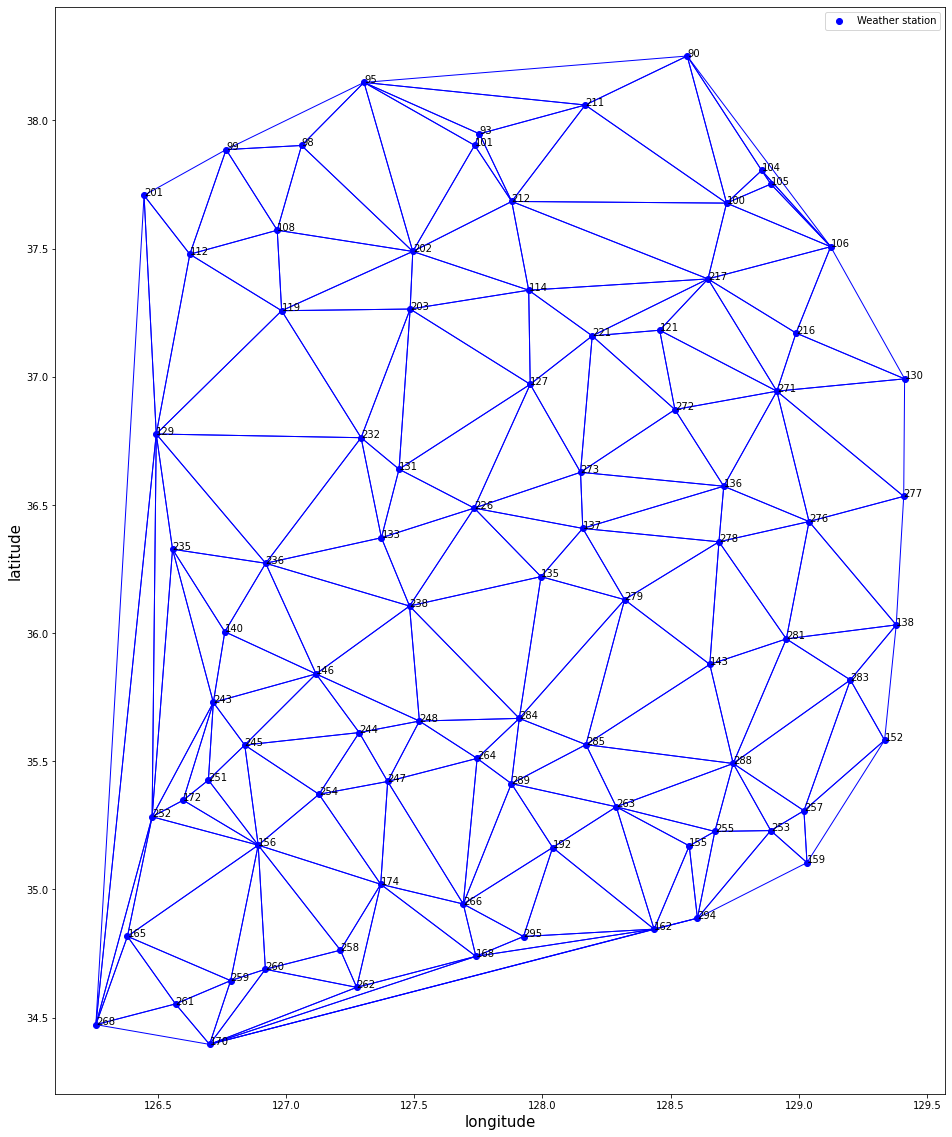

In [9]:
weather_station_X, weather_station_Y = weather_loc[:,0], weather_loc[:,1]

fig = plt.figure(figsize=(20,20))
axes = plt.subplot(1,1,1)
scat = axes.scatter(weather_station_X, weather_station_Y, alpha=0)

# for i in range(len(PV_loc)):
#   addPoint(scat, PV_loc[i])

for i, txt in enumerate(weather_num):
    plt.annotate(txt, (weather_station_X[i], weather_station_Y[i]))

colors=[]
markers = []
labels_ = []
for i in range(scat.get_offsets().data.shape[0]):
  if i < weather_loc.shape[0]:
    colors.append('b')
    markers.append('o')
    labels_.append('Weather station')
  # else:
  #   colors.append('r')
  #   markers.append('+')
  #   labels_.append('PV site')


total_X, total_Y = scat.get_offsets()[:,0], scat.get_offsets()[:,1]
for i in range(scat.get_offsets().data.shape[0]):
  plt.scatter(total_X[i], total_Y[i], marker=markers[i], color=colors[i], label=labels_[i])

segments = voronoi(weather_loc) # Voronoi Points!
lines = matplotlib.collections.LineCollection(segments, color='k', alpha=0)
axes.add_collection(lines)

# Stop matplotlib repeating labels in legend
# reference: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

axes.set_aspect('equal')

plt.xlabel('longitude', fontsize=15)
plt.ylabel('latitude', fontsize=15)


plt.show()

## Select PVs that belong to Delaunay triangles

In [23]:
"""
Description: (This simple example triangulates 10 random points, a further 3 random points are generated and) if they fall inside a triangle the vertices are given
The simplest (and quite optimal) algorithm is checking on which side of the half-plane created by the edges the point is.

Reference: https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle
"""

import warnings
warnings.filterwarnings(action='ignore')

def sign(Point1, Point2, Point3):
  # determinant
  return ((Point1[0]-Point3[0])*(Point2[1]-Point3[1]) )- ((Point2[0]-Point3[0])*(Point1[1]-Point3[1]))
  
def IsPointInTri(p, simplice):
  v1, v2, v3 = simplice[0], simplice[1], simplice[2]
  d1 = sign(p, v1, v2)
  d2 = sign(p, v2, v3) 
  d3 = sign(p, v3, v1)

  has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
  has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

  return not (has_neg and has_pos)


delauny = Delaunay(weather_loc)
triangles = delauny.points[delauny.vertices]

p_cnt = 0
PV_delaunay_spot = pd.DataFrame()
for point in PV_loc:
  for triangle in triangles:
    if IsPointInTri(point,triangle):
      # convert this information to DataFrame
      PV_del = PV_points[(PV_points['longitude'] == point[0]) | (PV_points['latitude'] == point[1])]
      weather_del = weather_points[(weather_points['longitude'] == triangle[0][0])|(weather_points['latitude'] == triangle[0][1])|
                                       (weather_points['longitude'] == triangle[1][0])|(weather_points['latitude'] == triangle[1][1])|
                                       (weather_points['longitude'] == triangle[2][0])|(weather_points['latitude'] == triangle[2][1])]
      PV_del.reset_index(inplace=True, drop=True)
      weather_del.reset_index(inplace=True, drop=True)
      for i in range(len(weather_del)):
        PV_del.loc[:,'지점'+str(i)] = weather_del.loc[i,'지점']
        PV_del.loc[:,'지점번호'+str(i)] = weather_del.loc[i,'지점번호']
        PV_del.loc[:,'latitude(지점)'+str(i)] = weather_del.loc[i,'latitude']
        PV_del.loc[:,'longitude(지점)'+str(i)] = weather_del.loc[i,'longitude']
      
      PV_delaunay_spot = pd.concat([PV_delaunay_spot, PV_del], axis=0)
      p_cnt += 1

## convert DataFrame to csv
PV_delaunay_spot = PV_delaunay_spot[PV_delaunay_spot.duplicated() == False]
PV_delaunay_spot.reset_index(inplace=True, drop=True)
# PV_delaunay_spot.to_csv(r'D:\Workspace\논문투고용code\DelFed_PV\PV_delaunay_tri(bell)_20211028(updated).csv',encoding='utf-8-sig', index=False)

In [1]:
PV_delaunay_spot.head()

* Plot the final DT visualization that PVs belong to DT

In [10]:
PV_del_class_true = PV_delaunay_spot.loc[:,['longitude', 'latitude']].values

weather_station_X, weather_station_Y = weather_loc[:,0], weather_loc[:,1]

fig = plt.figure(figsize=(26,26))
axes = plt.subplot(1,1,1)

scat = axes.scatter(weather_station_X, weather_station_Y, alpha=0)

for i in range(len(PV_del_class_true)):
  addPoint(scat, PV_del_class_true[i])

for i, txt in enumerate(weather_num):
    plt.annotate(txt, (weather_station_X[i], weather_station_Y[i]), fontsize=25)

# Delaunay에 속하는 PV 사이트 class 시각화 정보 선언
colors=[]
markers = []
labels_ = []
s_ = []
for i in range(weather_loc.shape[0] + PV_del_class_true.shape[0]):
  if i < weather_loc.shape[0]:
    colors.append('blue')
    markers.append('o')
    labels_.append('Weather station')
    s_.append(200)
  else:
    colors.append('red')
    markers.append('P')
    labels_.append('PV site')
    s_.append(200)

total_X, total_Y = scat.get_offsets()[:,0], scat.get_offsets()[:,1]
for i in range(scat.get_offsets().data.shape[0]):
  plt.scatter(total_X[i], total_Y[i], marker=markers[i], color=colors[i], label=labels_[i], s=s_[i])

segments = voronoi(weather_loc)
lines = matplotlib.collections.LineCollection(segments, color='k', alpha=0, linewidth=2)
axes.add_collection(lines)

# Stop matplotlib repeating labels in legend
# reference: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 45}, loc='lower right')

axes.set_aspect('equal')

plt.show()

## Visualization of Specific Delaunay Triangle 

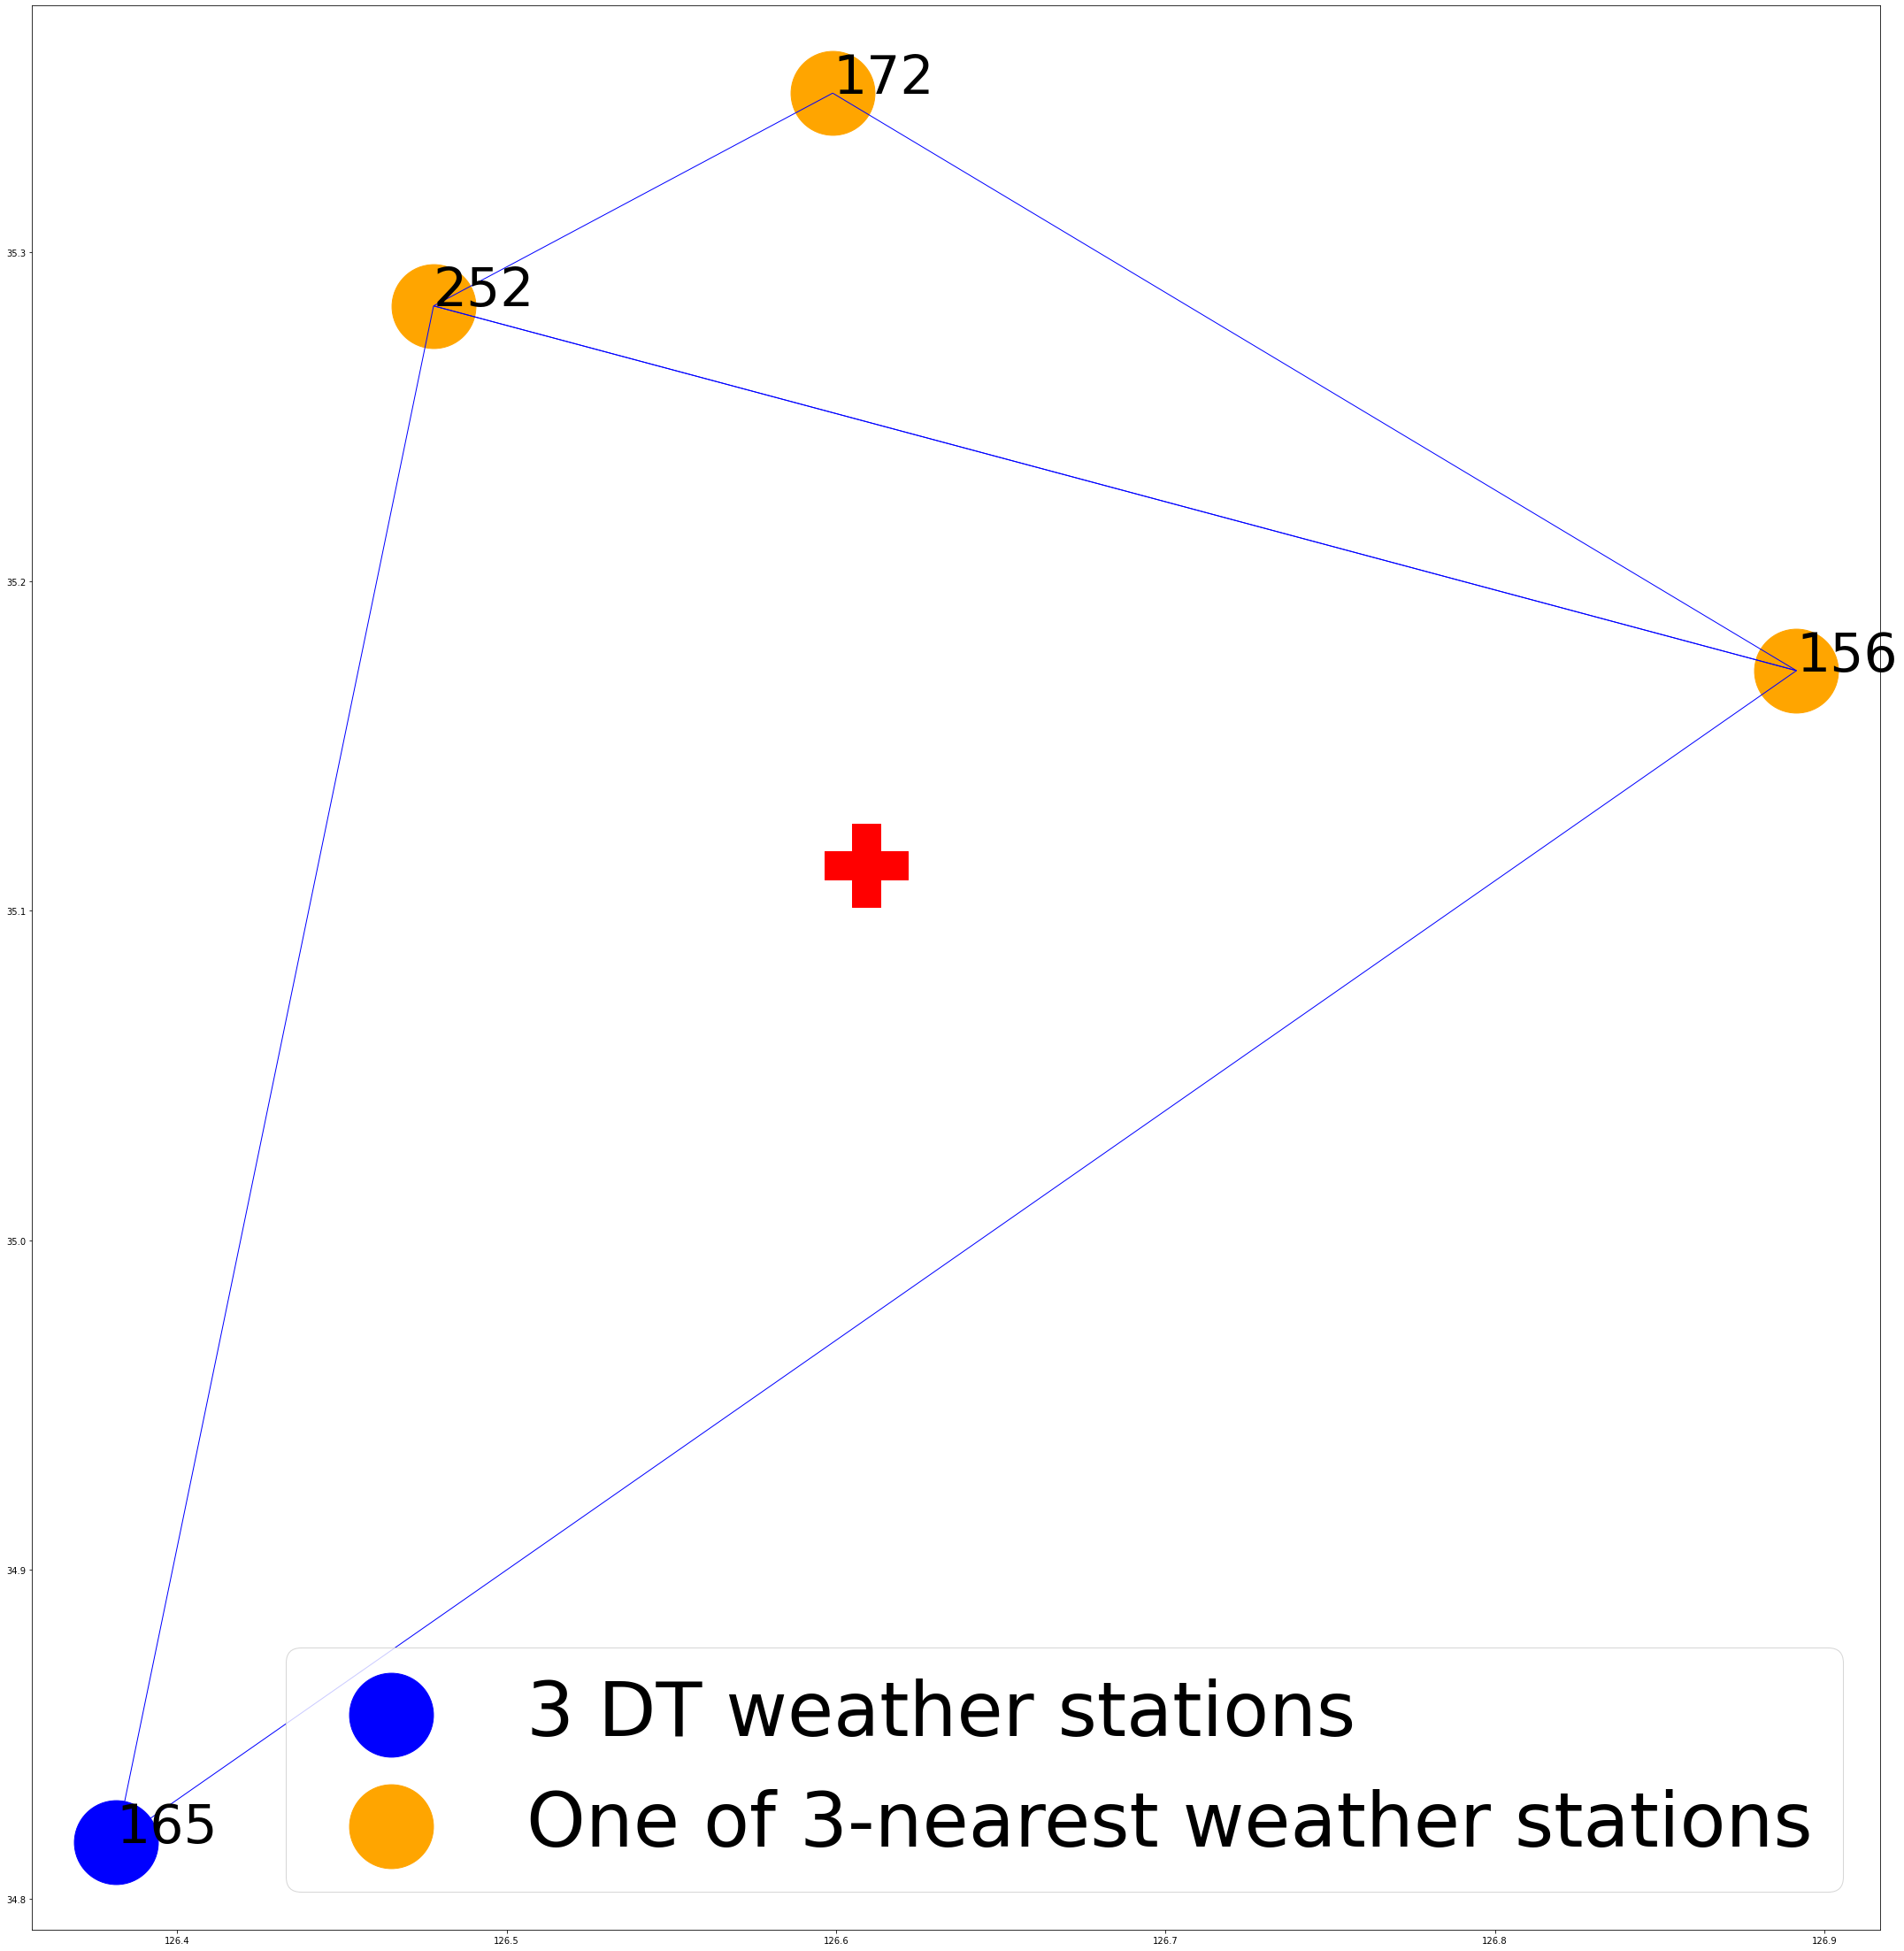

In [33]:
sampled_weather_points = weather_points[(weather_points['지점번호'] == 156) | (weather_points['지점번호'] == 165) | (weather_points['지점번호'] == 252) | (weather_points['지점번호'] == 172)]
sampled_weather_points.reset_index(drop=True, inplace=True)
sampled_weather_num = sampled_weather_points['지점번호'].values
sampled_weather_loc = np.concatenate([sampled_weather_points['longitude'].values.reshape(-1,1), sampled_weather_points['latitude'].values.reshape(-1,1)], axis=1) 

weather_station_X, weather_station_Y = sampled_weather_loc[:,0], sampled_weather_loc[:,1]


sample_del_pv = PV_delaunay_spot[PV_delaunay_spot['발전기명'].isin(['함평쏠라태양광'])]
sample_del_pv.reset_index(drop=True, inplace=True)
sample_pv_names = sample_del_pv["발전기명"].values.tolist()

nearest_weather_index = []
for i in range(len(sample_pv_names)):
    nearest_weather_station = pd.read_csv(r"D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\Expection_result\each_PV_weather_dist_euclidean/"+
                                      "PV_"+sample_pv_names[i]+"_dist_weather.csv")
    nearest_weather_index += sampled_weather_points[sampled_weather_points['지점번호'].isin(nearest_weather_station["지점번호"].values.tolist()[:3])].index.tolist()

PV_del_class_true = sample_del_pv.loc[:,['longitude', 'latitude']].values

fig = plt.figure(figsize=(40,40))
axes = plt.subplot(1,1,1)

scat = axes.scatter(weather_station_X, weather_station_Y, alpha=0)

for i in range(len(PV_del_class_true)):
  addPoint(scat, PV_del_class_true[i])

for i, txt in enumerate(sampled_weather_num):
    plt.annotate(txt, (weather_station_X[i], weather_station_Y[i]), fontsize=60)

colors=[]
markers = []
labels_ = []
s_ = []
for i in range(sampled_weather_loc.shape[0] + PV_del_class_true.shape[0]):
  if i < sampled_weather_loc.shape[0]:
    
    if i not in nearest_weather_index:
      colors.append('blue')
      markers.append('o')
      labels_.append('3 DT weather stations')
      s_.append(9000)
    else:
      colors.append('Orange')
      markers.append('o')
      labels_.append('One of 3-nearest weather stations')
      s_.append(9000)
  else:
    colors.append('red')
    markers.append('P') # P
    # labels_.append('PV site')
    labels_.append('')
    
    s_.append(9000)

total_X, total_Y = scat.get_offsets()[:,0], scat.get_offsets()[:,1]
for i in range(scat.get_offsets().data.shape[0]):
  plt.scatter(total_X[i], total_Y[i], marker=markers[i], color=colors[i], label=labels_[i], s=s_[i])

segments = voronoi(sampled_weather_loc)
lines = matplotlib.collections.LineCollection(segments, color='k', alpha=0)
axes.add_collection(lines)

# Stop matplotlib repeating labels in legend
# reference: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# reorder indicies for visualization 
by_label = {'3 DT weather stations':by_label['3 DT weather stations'], 'One of 3-nearest weather stations':by_label['One of 3-nearest weather stations']}
plt.legend(by_label.values(), by_label.keys(), prop={'size': 85}, loc='lower right')

axes.set_aspect('equal')

plt.show()